# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim

#vectorize the data
from sklearn.feature_extraction.text import TfidfVectorizer

#tokenize the data
import re
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.data.path.append('/path/to/nltk_data')

#similarity metric
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load the data

In [3]:
data = pd.read_csv("/kaggle/input/coursera-courses-dataset-2021/Coursera.csv")
data.head()

,Course Name,University,Difficulty Level,Course Rating,Course URL,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


In [4]:
data.rename(columns={"University": "Educator"}, inplace=True)

# About the data

Choosing the wrong courses can cost us a lot of time and money, so it is 
very important to choose the right courses for us. Recommender systems can 
help us here, which will recommend ideal courses for us based on our 
interests and future goals.

This dataset was scraped off the publicly available information on the Coursera website in September 2021 and manually entered in the case where the data was improperly scraped. It can be used in Recommender Systems to promote Coursera courses based on the Difficulty Level and the Skills needed.

Key Attributes:
- Course Name;
- University: The University or Industry Partner that offers the Course;
- Difficulty Level: Beginner, Intermediate, Advanced. Also has Missing Values represented by Not Calibrated;
- Course Rating: Rating on a 5-point scale with minimum step value 0.1. Missing Values represented by Not Calibrated;
- Course URL;
- Course Description.

# Objectives

-  Main goal is to create a  course recommender system. The model successfully recommends new courses based on desired courses. It checks if the course title exists in a list of courses, computes how similar each course is to the given one, and then sorts and returns the top 5 most similar courses.
- The secondary goal is to explore the data, clean it and do a basic EDA analysis.

# EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Name         3522 non-null   object
 1   Educator            3522 non-null   object
 2   Difficulty Level    3522 non-null   object
 3   Course Rating       3522 non-null   object
 4   Course URL          3522 non-null   object
 5   Course Description  3522 non-null   object
 6   Skills              3522 non-null   object
dtypes: object(7)
memory usage: 192.7+ KB


The dataset contains 3522 entries and 7 columns. We have 7 categorical columns. Based on this, it says that there are no null values, but in the description of the dataset it says that they are defined as "Not Calibrated", so we will find and deal with them.


In [6]:
# Replace "Not Calibrated" with NaN
data.replace("Not Calibrated", np.nan, inplace=True)

# Check for null values in the dataset
data.isnull().sum()

Course Name            0
Educator               0
Difficulty Level      50
Course Rating         82
Course URL             0
Course Description     0
Skills                 0
dtype: int64

In [7]:
# Convert the column to float
data["Course Rating"] = data["Course Rating"].astype(float)

In [8]:
# Fill missing values in the 'Course Rating' column with the mean value of the 'Course Rating' column
data['Course Rating'] = data['Course Rating'].fillna(data['Course Rating'].mean())

Null values were found in the Difficulty Level and Course Rating columns. We converted the Course Rating column to float from object, because it contains only numerical values, and then replaced null values with the mean value of that column. We will not do anything in the Difficulty Level column, because it is not important for further analysis.

Educator
Coursera Project Network                      562
University of Illinois at Urbana-Champaign    138
Johns Hopkins University                      110
University of Michigan                        101
University of Colorado Boulder                101
Google Cloud                                   88
University of California, Irvine               88
IBM                                            84
University of Colorado System                  83
University of California San Diego             81
Name: count, dtype: int64

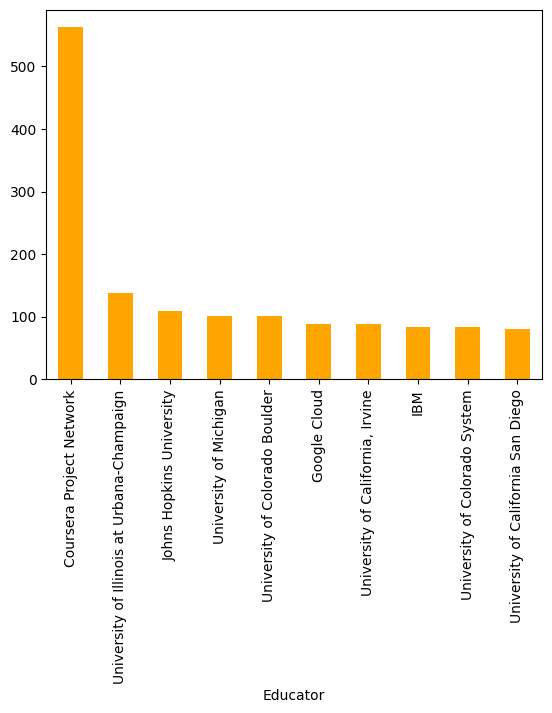

In [9]:
#top ten educators based on number of courses
data["Educator"].value_counts().head(10).plot.bar(color='orange')
data["Educator"].value_counts().head(10)

The top 5 educators in Coursera based on the number of courses are: Coursera Project Network, University of Illinois at Urbana-Champaign, Johns Hopkins University, University of Michigan, University of Colorado Boulder, which is Coursera Project Network in a convincing lead with 562 courses.

In [10]:
data["Difficulty Level"].value_counts()

Difficulty Level
Beginner        1444
Advanced        1005
Intermediate     837
Conversant       186
Name: count, dtype: int64

The largest number of courses is the beginner level, with 1444 courses, followed immediately by the Advanced level with 1005 courses.

<Axes: xlabel='Course Rating'>

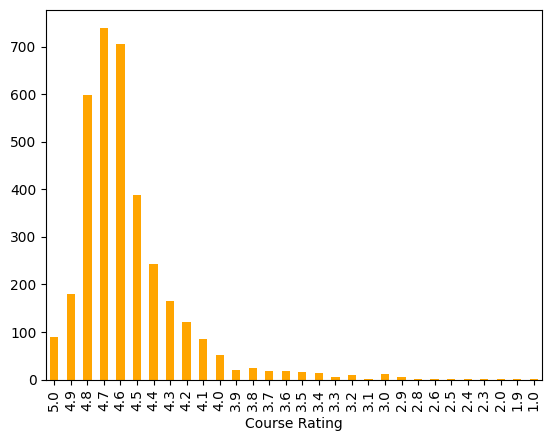

In [11]:
#ratings of courses
data["Course Rating"].round(1).value_counts().sort_index(ascending=False).plot(kind ="bar", color="orange")

In [12]:
data[data['Course Rating'] == 5.0].head()

,Course Name,Educator,Difficulty Level,Course Rating,Course URL,Course Description,Skills
27,AWS Elastic Beanstalk: Build & Deploy a Node.j...,Coursera Project Network,Advanced,5.0,https://www.coursera.org/learn/nodejs-api-aws-...,"In this 1-hour long project-based course, you ...",representational state transfer uniform resou...
33,Advanced Speaking and Listening Project,"University of California, Irvine",Advanced,5.0,https://www.coursera.org/learn/speaking-listen...,Learners will present a well-organized academi...,project rapid serial visual presentation pan...
60,Change Leadership: Developing Force Field Anal...,Coursera Project Network,Advanced,5.0,https://www.coursera.org/learn/change-force-an...,"By the end of this guided project, you will be...",business case personal advertisement Mapping...
69,Create an FPS Weapon in Unity (Part 1 - Revolver),Coursera Project Network,Advanced,5.0,https://www.coursera.org/learn/create-fps-weap...,"In this one-hour, project-based course, you'll...",gamification of learning project process .p...
75,Animals and Institutions,University of Colorado Boulder,Beginner,5.0,https://www.coursera.org/learn/animals-institu...,This course explores animals within the contex...,livestock animal veterinary veterinary medi...


In [13]:
data.loc[27, 'Course Name']

'AWS Elastic Beanstalk: Build & Deploy a Node.js RESTful API'

The largest number of courses was rated with a rating of over 4.0, which means that users are very satisfied with the content offered by Coursera.

Top rated courses by "Course Rating" == 5.0 are: 
- AWS Elastic Beanstalk: Build & Deploy a Node.js RESTful API (Advanced Difficulty Level) and 
- Animals and Institutions (Beginner Difficulty Level).

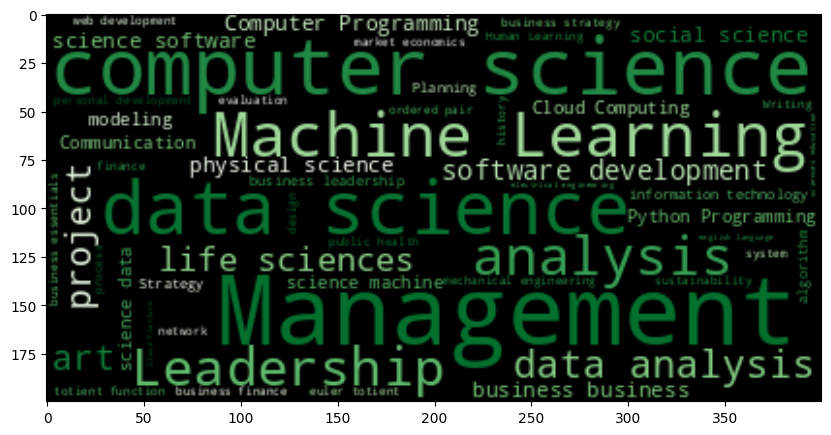

In [14]:
skills = data['Skills'].values

text = ' '.join(skills)

# English Stopwords
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color='black', colormap='Greens').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In the word cloud we can see that the most frequent/important words in the Skills columns are: Management, Machine Learning, computer science, which means that these skills are more frequent in the courses.

Important columns:
- Course name;
- Course Description;
- Skills.

Unimportant columns:
- Course Rating;
- Educator;
- Course URL;
- Difficulty Level.

We'will make a new column "tags" that will show us what each course is all about by combining its name, description, and skills into one big description. This helps us understand each course better and find other courses that are similar to it!

In [15]:
#new column "tags"
data['tags'] = data['Course Name']  + data['Course Description'] + data['Skills']

In [16]:
#removing unimportant columns
data = data.drop(["Course Rating", "Educator", "Course URL", "Difficulty Level", "Course Description", "Skills"], axis=1)

In [17]:
data.head()

,Course Name,tags
0,Write A Feature Length Screenplay For Film Or ...,Write A Feature Length Screenplay For Film Or ...
1,Business Strategy: Business Model Canvas Analy...,Business Strategy: Business Model Canvas Analy...
2,Silicon Thin Film Solar Cells,Silicon Thin Film Solar CellsThis course consi...
3,Finance for Managers,"Finance for ManagersWhen it comes to numbers, ..."
4,Retrieve Data using Single-Table SQL Queries,Retrieve Data using Single-Table SQL QueriesIn...


In [18]:
#rename column "Course Name" to "course_title" 
data.rename(columns={"Course Name": "course_title"}, inplace=True)

With function **clean_text** we will clean and preprocess the text by converting it to lowercase, removing special characters, tokenizing into words, removing stopwords, and returning a cleaned version of the text.

In [19]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stopwords = set(STOPWORDS)
    filtered_tokens = [word for word in tokens if word not in stopwords]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

In [20]:
data['tags'] = data['tags'].apply(clean_text)

In [21]:
data.head()

,course_title,tags
0,Write A Feature Length Screenplay For Film Or ...,write feature length screenplay film televisio...
1,Business Strategy: Business Model Canvas Analy...,business strategy business model canvas analys...
2,Silicon Thin Film Solar Cells,silicon thin film solar cellsthis course consi...
3,Finance for Managers,finance managerswhen comes numbers always meet...
4,Retrieve Data using Single-Table SQL Queries,retrieve data using singletable sql queriesin ...


In [22]:
data['tags'].iloc[4]

'retrieve data using singletable sql queriesin course youll learn effectively retrieve data relational database table using sql language know computer systems rely least one database store data tax information stored database used internal revenue service phone stores contacts names addresses email addresses phone numbers database shop online youre viewing photos descriptions prices products stored database database designers go great lengths design databases data stored securely organized format important note main reason go work data back need thats called data retrieval data retrieved read relational database using language called sql query question database sql referred language relational databases used embedded programs retrieve data data retrieved displayed web page pc application even printed paper youll practicing writing sql queries using sqlitestudio next time go online look daily special favorite restaurant think fact likely sql query used behind scenes fetch data pop scree

# Cosine similarity matrix

This code transforms course tags into numerical form, calculates similarity between courses, and mapping course titles to indices. This preprocessing is crucial for efficiently generating course recommendations based on tags similarity.

**TfidfVectorizer()** Converts the text data in the 'tags' column into numerical vectors. TF-IDF (Term Frequency-Inverse Document Frequency) gives a measure of the importance of each word relative to other words in the dataset. 
- To help our model work with text inputs, we need to convert them into a format that computers can understand. This means turning words and sentences into numerical representations. By doing this, we make it possible for the model to analyze the text and find patterns that it can use to make predictions or recommendations. This process essentially translates human language into a language that machines can process and learn from effectively.

**Cosine similarity calculation** Computes the cosine similarity between each pair of courses based on their TF-IDF vectors. Cosine similarity measures the cosine of the angle between two vectors, which indicates how similar the courses are to each other. This similarity matrix is used to find courses that are most similar to a given course.

**Mapping Course Titles to Indices** Creates a mapping from course titles to their respective indices in the DataFrame. This allows for quick lookup of the index for any given course title, enabling efficient retrieval of similarity scores for recommendations.

In [23]:
def compute_cosine_similarity(data):
    """
    Computes the cosine similarity matrix for the course titles.
    
    Parameters:
    DataFrame with 'tags' and 'course_titles' columns.
    
    Returns:
    tuple: A tuple containing the cosine similarity matrix and a mapping of course titles to indices.
    """
    # Vectorization
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(data['tags'])
    
    # Cosine similarity calculation
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Mapping of course titles to indices
    indices = pd.Series(data.index, index=data['course_title']).drop_duplicates()
    
    return cosine_sim, indices

In [24]:
# Compute cosine similarity matrix and indices mapping
cosine_sim, indices = compute_cosine_similarity(data)

# Recommendation Function

The recommendations function efficiently retrieves and ranks courses based on their similarity to a given course_title. It ensures that only valid course titles are processed, retrieves similarity scores, sorts them, and returns the top recommendations. 

In [25]:
def recommendations(course_title):
    
    
    #Index Retrieval
    idx = indices[course_title]
    
    #Similarity Score Calculation
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    
    #Retrieve Recommended Courses
    course_indices = [i[0] for i in sim_scores]
    return data['course_title'].iloc[course_indices]


In [26]:
data['course_title'].head(30)

0     Write A Feature Length Screenplay For Film Or ...
1     Business Strategy: Business Model Canvas Analy...
2                         Silicon Thin Film Solar Cells
3                                  Finance for Managers
4          Retrieve Data using Single-Table SQL Queries
5     Building Test Automation Framework using Selen...
6                      Doing Business in China Capstone
7                         Programming Languages, Part A
8     The Roles and Responsibilities of Nonprofit Bo...
9                Business Russian Communication. Part 3
10         Agile Projects:  Developing Tasks with Taiga
11                  Esports Management Capstone Project
12                                 Hacking and Patching
13            Business Statistics and Analysis Capstone
14    Grab Data Fast with Vertical and Horizontal LO...
15         Global Health: An Interdisciplinary Overview
16                        Python Programming Essentials
17    Creating Dashboards and Storytelling with 

In [27]:
recommendations('Silicon Thin Film Solar Cells')

2854               Physics of silicon solar cells
438                   Introduction to solar cells
2144    Organic Solar Cells - Theory and Practice
742                           Solar Energy Basics
835                 Solar Energy Systems Overview
Name: course_title, dtype: object

In [28]:
recommendations('Business Statistics and Analysis Capstone')

2550                     Statistics with R Capstone
152            Marketing Analytics Capstone Project
1204                 Introduction to Data Analytics
3001    Foundations of strategic business analytics
3217      Introduction to Business Analytics with R
Name: course_title, dtype: object

# Conclusion

The model successfully recommends new courses based on desired courses.
The recommendations function is designed to find and suggest courses that are similar to a given course title based on their skills or descriptions. It checks if the course title exists in a list of courses, computes how similar each course is to the given one, and then sorts and returns the top 5 most similar courses.